# Introduction

I would like to know if Wageningen and its surroundings have changed with respect to its spring NDVI over the past 15 years. For that I would need to do a bi-temporal comparison of two NDVI images, acquired in spring. Simply subtracting the images should work, but unfortunately these haven't been pre-processed yet. I managed to download two Landsat raw surface reflectance products covering the area. They were acquired around the same period of the year, but about 30 years apart from each other. I don't know how to compare them. Can you please help me?

In [2]:
# install and import packages
if(!("raster" %in% rownames(installed.packages()))) {
  install.packages("raster")}
if(!("rgdal" %in% rownames(installed.packages()))) {
  install.packages("rgdal")}
if(!("testthat" %in% rownames(installed.packages()))) {
  install.packages("testthat")}

library(raster)
library(rgdal)
library(testthat)

Installing package into ‘/home/fed/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Loading required package: sp
rgdal: version: 1.3-6, (SVN revision 773)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


In [ ]:
#create dir for data and download
dir.create(file.path(getwd(), 'data'))

#download data and unzip 
download.file(url='https://www.dropbox.com/sh/3lz5vylc7tzpiup/AAB3HCFHdJFa8lV_PMRlV5Wda?dl=1', destfile='data/landsat_data.zip', method='auto')
unzip(zipfile='data/landsat_data.zip', exdir='data')
untar(tarfile = 'data/LC81970242014109-SC20141230042441.tar.gz',exdir='data/present')
untar(tarfile = 'data/LT51980241990098-SC20150107121947.tar.gz',exdir='data/past')


# Assignment and additional info

landsat 8 specifications https://landsat.usgs.gov/sites/default/files/documents/Landsat8DataUsersHandbook.pdf

landsat 5 specifications https://landsat.usgs.gov/sites/default/files/documents/ledaps_product_guide.pdf

Note: Landsat 8 does not use the same band numbers as its predecessors. Red and NIR correspond to band3 and band4 respectively for ETM+ and TM (Landsat 7 and 5 respectively), while for OLI (Landsat 8), Red is band4 and NIR is band5

Hints

* list.files() with pattern = argument. For example, list.files('data/', pattern = glob2rx('*.tif'), full.names = TRUE) will return only the files that have the .tif extension.
* you should always use full.names = TRUE in list.files() to be able to use the output directly.
* intersect
* untar() to programmatically extract the files from the archive.


Warning message in dir.create(file.path(getwd(), "data")):
“'/home/fed/Documents/Ported_exerc/data' already exists”

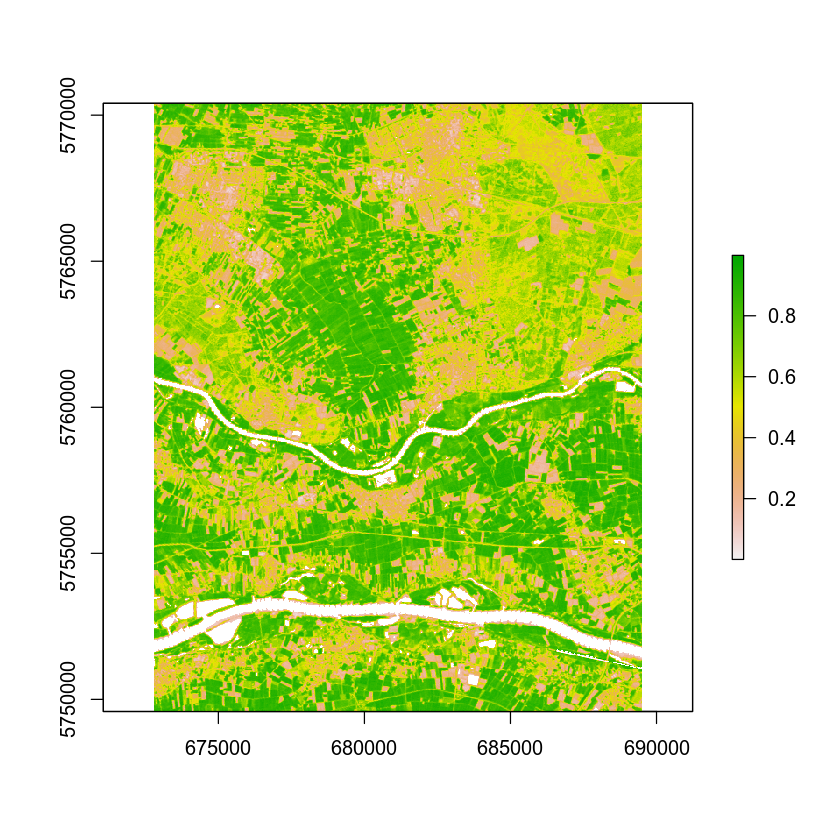

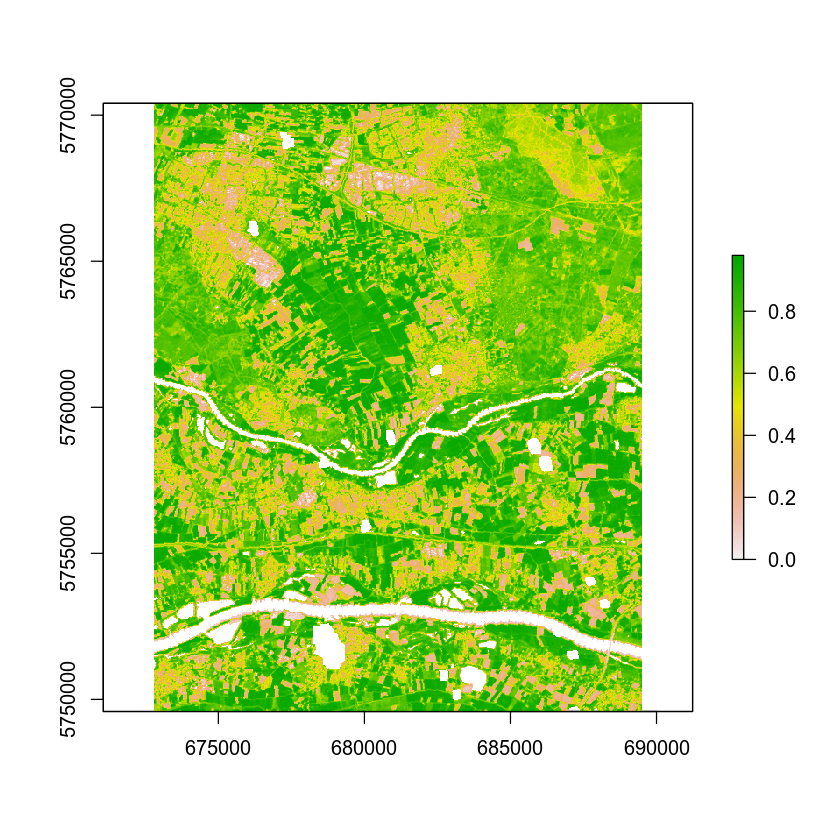

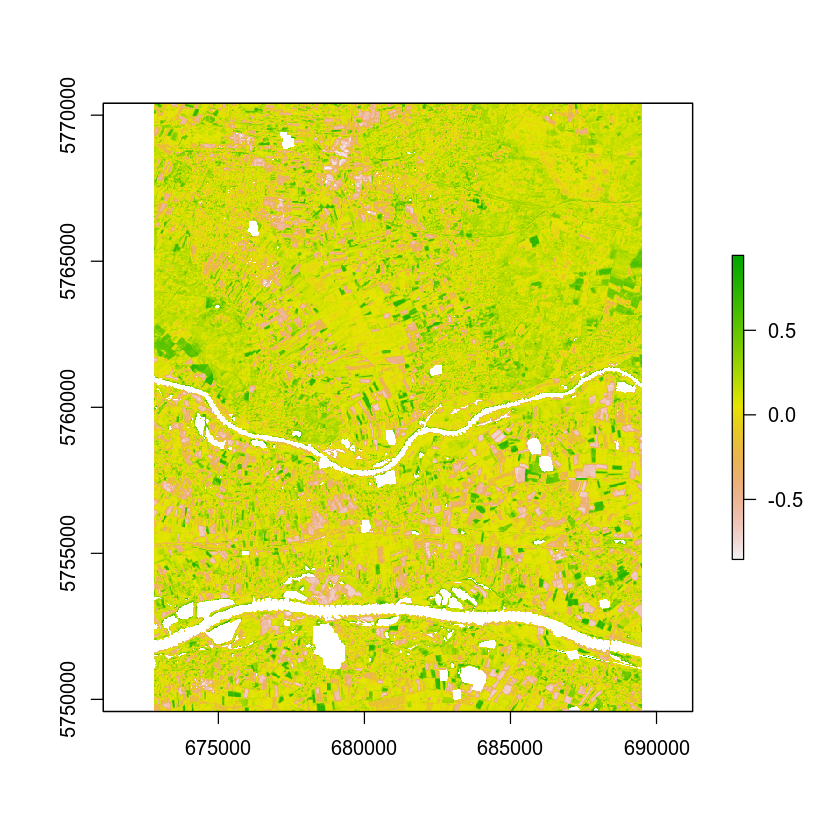

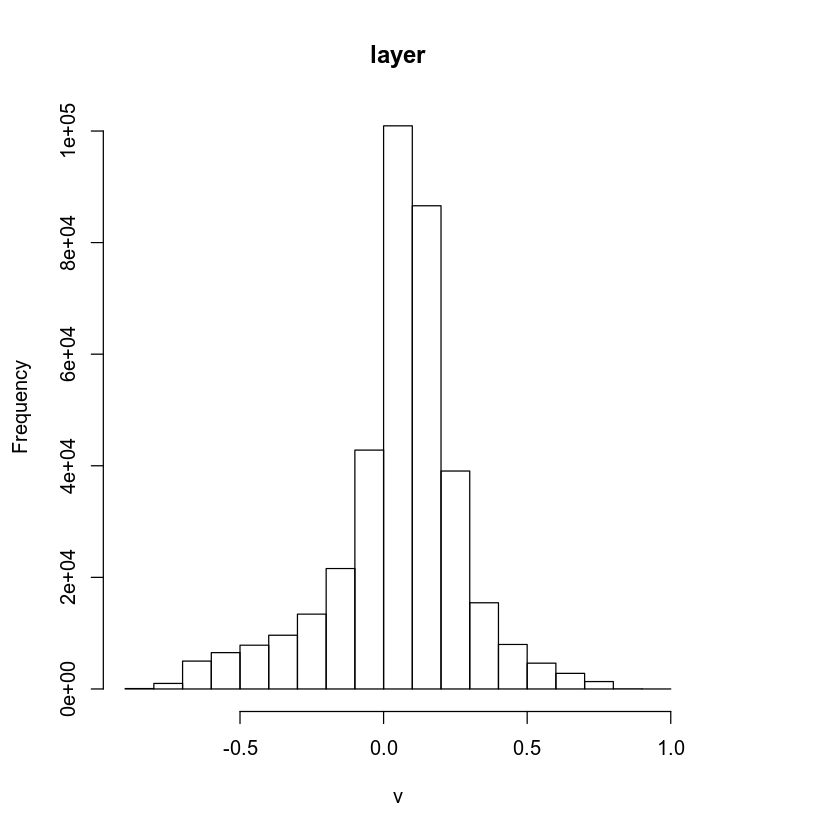

In [3]:
#note:at the very least, your final answer MUST be assigned to a variable called "ndvi_diff"

### BEGIN SOLUTION

# create list with bands for past and present image
past_list=list.files(path='data/past/', pattern = glob2rx('*.tif'), full.names=TRUE)
present_list=list.files(path='data/present/', pattern = glob2rx('*.tif'), full.names=TRUE)
past_stack = stack(past_list)
present_stack = stack(present_list)


#set extent and crop
past_extent=extent(past_stack[[1]])
present_extent=extent(present_stack[[1]])

past_cropped = intersect(x=past_stack,y=present_stack)
present_cropped = intersect(x=present_stack,y=past_stack)


#define function to set pixels to NA according to a cloudmask
cloud2NA <- function(x, y){
  x[y != 0] <- NA
  return(x)
}

#remove clouds

past_cloudfree <- overlay(x = past_cropped, y = past_cropped$LT51980241990098KIS00_cfmask, fun = cloud2NA)
present_cloudfree <- overlay(x = present_cropped, y = present_cropped$LC81970242014109LGN00_cfmask, fun = cloud2NA)

# calculating NDVI
#past (landsat 5) nir band: 4 , red band: 3, these are elements 7 and 6 in the list
#present (landsat 8) nir band: 5, red band: 4 , these are elements 6 and 5 in the list

ndvi_past = (past_cloudfree[[7]] - past_cloudfree[[6]]) / (past_cloudfree[[7]] + past_cloudfree[[6]])
ndvi_present = (present_cloudfree[[6]] - present_cloudfree[[5]]) / (present_cloudfree[[6]] + present_cloudfree[[5]])

#cleanup NDVI values: remove values not conforming to: 0<value<1
ndvi_past[ndvi_past>1|ndvi_past<0] =  NA
ndvi_present[ndvi_present>1|ndvi_present<0] =  NA

#visualize intermediate result
plot(ndvi_past)
plot(ndvi_present)

#temporal difference (subtract) NDVI
ndvi_diff = ndvi_present-ndvi_past

#visualize end result
plot(ndvi_diff)
hist(ndvi_diff)

#write end result to disk
dir.create(path='output')
writeRaster(x=ndvi_diff, filename='output/ndvi_diff.tif')

### END SOLUTION


In [18]:
expect_true(cellStats(ndvi_diff, "mean")<0.055)
expect_true(cellStats(ndvi_diff, "mean")>0.045)

expect_true(dim(ndvi_diff)[1]==694)
expect_true(dim(ndvi_diff)[2]==557)

### BEGIN HIDDEN TESTS
TeachSolution=raster('TeachersSolutionFolder/ndvi_diff.tif')
StudSolution=ndvi_diff
TeachSolution==StudSolution
expect_lt(cellStats(TeachSolution-StudSolution, "sum"),0.0001) #expect less than 0.0001, the sum of all differences between ref raster
### END HIDDEN TESTS

class       : RasterLayer 
dimensions  : 694, 557, 386558  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 672793, 689503, 5749586, 5770406  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=31 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
data source : in memory
names       : layer 
values      : 0, 1  (min, max)
